# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# Define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = data['filenames']
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# Load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# Print statistics about the dataset
print(f'There are {len(dog_names)} total dog categories.')
print(f'There are {len(train_files) + len(valid_files) + len(test_files)} total dog images.')
print(f'There are {len(train_files)} training dog images.')
print(f'There are {len(valid_files)} validation dog images.')
print(f'There are {len(test_files)} test dog images.')

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [6]:
test_files

array(['../../../data/dog_images/test/057.Dalmatian/Dalmatian_04056.jpg',
       '../../../data/dog_images/test/059.Doberman_pinscher/Doberman_pinscher_04156.jpg',
       '../../../data/dog_images/test/115.Papillon/Papillon_07480.jpg',
       '../../../data/dog_images/test/019.Bedlington_terrier/Bedlington_terrier_01363.jpg',
       '../../../data/dog_images/test/068.Flat-coated_retriever/Flat-coated_retriever_04703.jpg',
       '../../../data/dog_images/test/021.Belgian_sheepdog/Belgian_sheepdog_01548.jpg',
       '../../../data/dog_images/test/043.Canaan_dog/Canaan_dog_03072.jpg',
       '../../../data/dog_images/test/052.Clumber_spaniel/Clumber_spaniel_03715.jpg',
       '../../../data/dog_images/test/097.Lakeland_terrier/Lakeland_terrier_06518.jpg',
       '../../../data/dog_images/test/051.Chow_chow/Chow_chow_03664.jpg',
       '../../../data/dog_images/test/002.Afghan_hound/Afghan_hound_00116.jpg',
       '../../../data/dog_images/test/019.Bedlington_terrier/Bedlington_terrier_01

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# Load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# Print statistics about the human dataset
print(f'There are {len(human_files)} total human images.')

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


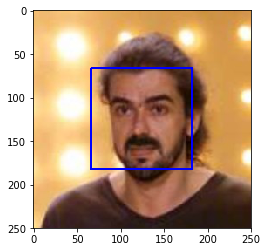

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[8])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
is_human_human = [face_detector(img) for img in human_files_short]
perc_human_human = 100 * np.mean(is_human_human)
print("{:.0f}% of the first 100 images in human_files have a detected human face"
          .format(perc_human_human))

is_dog_human = [face_detector(img) for img in dog_files_short]
perc_dog_human = 100 * np.mean(is_dog_human)
print("{:.0f}% of the first 100 images in dog_files have a detected human face"
          .format(perc_dog_human))

100% of the first 100 images in human_files have a detected human face
11% of the first 100 images in dog_files have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ Expecting users to provide the perfect input data is not necessarily a reasonable expectation. Various scenarios can lead to inadequate results and as a result user frustration. To enhance our face detector, we could develop a CNN tailored to detecting human faces under various conditions. This would involve training the model on a comprehensive dataset containing a wide array of human faces with partial obstructions, such as individuals not facing the camera directly, and wearing a hat or sunglasses.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

img_width, img_height = 224, 224

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
dog_vfunc = np.vectorize(dog_detector)
dog_dogs = dog_vfunc(dog_files_short)
dog_dogs

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
is_human_dog = [dog_detector(img) for img in human_files_short]
perc_human_human = 100 * np.mean(is_human_dog)
print("{:.0f}% of the first 100 images in human_files have a detected dog"
          .format(perc_human_human))

is_dog_dog = [dog_detector(img) for img in dog_files_short]
perc_dog_human = 100 * np.mean(is_dog_dog)
print("{:.0f}% of the first 100 images in dog_files have a detected dog"
          .format(perc_dog_human))

0% of the first 100 images in human_files have a detected dog
100% of the first 100 images in dog_files have a detected dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading of truncated images

def image_generator(files, targets, batch_size):
    while True:
        batch_paths = np.random.choice(a=files, size=batch_size)
        batch_input = paths_to_tensor(batch_paths)
        valid_paths = [p for p in batch_paths if path_to_tensor(p) is not None]
        batch_indices = [np.where(files == img_path)[0][0] for img_path in valid_paths]
        batch_output = np.array([targets[index] for index in batch_indices])

        if len(batch_input) > 0:  # Ensure there is data to yield
            yield batch_input, batch_output

# Create generators for train, validation, and test datasets
train_generator = image_generator(train_files, train_targets, batch_size=64)
valid_generator = image_generator(valid_files, valid_targets, batch_size=64)
test_generator = image_generator(test_files, test_targets, batch_size=64)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I adopted the hinted architecure as it appears to be an efficient way of classifying images by capturing hierarchical features. The use of multiple 2D convolutional layers with increasing numbers of filters indicates that the model will capture basic features in the early layers such as edges and textures and then identify more complex patterns in later layers. The pooling layers in between reduce dimensionality of the input and as a result reduce computational complexity. And finally, the Dense layer uses a softmax Activation Function, which is suitable for multi-class classification tasks.

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size = (2, 2), padding = 'valid', activation = 'relu',
                input_shape = (img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Conv2D(filters=32, kernel_size = (2, 2), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Conv2D(filters=64, kernel_size = (2, 2), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(dog_names), activation='softmax'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [15]:
from keras.optimizers import Adam

# Set a smaller learning rate
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [22]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=2, save_best_only=True)

In [18]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

# Add checkpoint to save the best model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=2, save_best_only=True)

# ReduceLROnPlateau: This callback reduces the learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
model.fit_generator(train_generator,
                    steps_per_epoch=len(train_files) // 32,
                    validation_data=valid_generator,
                    validation_steps=len(valid_files) // 32,
                    epochs=epochs,
                    callbacks=[checkpointer, reduce_lr],
                    verbose=2)

 20%|██        | 13/64 [00:00<00:00, 126.96it/s]

Epoch 1/10


100%|██████████| 64/64 [00:00<00:00, 106.94it/s]


Epoch 00001: val_loss improved from inf to 4.82321, saving model to saved_models/weights.best.from_scratch.hdf5
 - 418s - loss: 5.7055 - acc: 0.0138 - val_loss: 4.8232 - val_acc: 0.0192


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2/10


100%|██████████| 64/64 [00:00<00:00, 97.77it/s]


Epoch 00002: val_loss improved from 4.82321 to 4.75741, saving model to saved_models/weights.best.from_scratch.hdf5
 - 410s - loss: 4.7584 - acc: 0.0223 - val_loss: 4.7574 - val_acc: 0.0192


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3/10


100%|██████████| 64/64 [00:00<00:00, 88.80it/s]


Epoch 00003: val_loss improved from 4.75741 to 4.73392, saving model to saved_models/weights.best.from_scratch.hdf5
 - 415s - loss: 4.6947 - acc: 0.0297 - val_loss: 4.7339 - val_acc: 0.0234


  9%|▉         | 6/64 [00:00<00:01, 55.77it/s]

Epoch 4/10


100%|██████████| 64/64 [00:00<00:00, 89.15it/s]


Epoch 00004: val_loss improved from 4.73392 to 4.68746, saving model to saved_models/weights.best.from_scratch.hdf5
 - 413s - loss: 4.6138 - acc: 0.0402 - val_loss: 4.6875 - val_acc: 0.0325


 16%|█▌        | 10/64 [00:00<00:00, 76.94it/s]

Epoch 5/10


100%|██████████| 64/64 [00:00<00:00, 87.99it/s]


Epoch 00005: val_loss did not improve
 - 408s - loss: 4.5168 - acc: 0.0492 - val_loss: 4.6988 - val_acc: 0.0481


 14%|█▍        | 9/64 [00:00<00:00, 83.18it/s]

Epoch 6/10


100%|██████████| 64/64 [00:00<00:00, 103.73it/s]


Epoch 00006: val_loss improved from 4.68746 to 4.62820, saving model to saved_models/weights.best.from_scratch.hdf5
 - 388s - loss: 4.4329 - acc: 0.0588 - val_loss: 4.6282 - val_acc: 0.0481


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7/10


100%|██████████| 64/64 [00:00<00:00, 95.22it/s]


Epoch 00007: val_loss improved from 4.62820 to 4.61505, saving model to saved_models/weights.best.from_scratch.hdf5
 - 393s - loss: 4.3188 - acc: 0.0688 - val_loss: 4.6151 - val_acc: 0.0583


 20%|██        | 13/64 [00:00<00:00, 122.31it/s]

Epoch 8/10


100%|██████████| 64/64 [00:00<00:00, 100.78it/s]


Epoch 00008: val_loss improved from 4.61505 to 4.51896, saving model to saved_models/weights.best.from_scratch.hdf5
 - 376s - loss: 4.2552 - acc: 0.0828 - val_loss: 4.5190 - val_acc: 0.0583


 19%|█▉        | 12/64 [00:00<00:00, 116.80it/s]

Epoch 9/10


100%|██████████| 64/64 [00:00<00:00, 78.31it/s]


Epoch 00009: val_loss improved from 4.51896 to 4.46009, saving model to saved_models/weights.best.from_scratch.hdf5
 - 395s - loss: 4.1678 - acc: 0.0903 - val_loss: 4.4601 - val_acc: 0.0535


 14%|█▍        | 9/64 [00:00<00:00, 57.95it/s]

Epoch 10/10


100%|██████████| 64/64 [00:00<00:00, 87.68it/s]


Epoch 00010: val_loss did not improve
 - 390s - loss: 4.0849 - acc: 0.0972 - val_loss: 4.5024 - val_acc: 0.0715


### Load the Model with the Best Validation Loss

In [30]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [31]:
# Evaluate the model on the test data using `evaluate_generator`
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_files) // 32)

# Convert the accuracy to percentage
test_accuracy = test_accuracy * 100

print('Test accuracy: %.4f%%' % test_accuracy)

100%|██████████| 64/64 [00:00<00:00, 84.37it/s]


Test accuracy: 5.4087%


With an accuracy of 5%, our model is currently not performing great. Although it is significantly better than results we would get from picking labels at random, there is still room for improvement. If we wanted to build upon these results it may be worth considering approaches such as image augmentation, adding additional convolutional layers and adding batch normalization.

However, the most efficient route will be transfer learning. In transfer learning, we re-use a pre-trained model and re-purpose it for another use.

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [24]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [25]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [26]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 481us/step - loss: 12.7197 - acc: 0.1150 - val_loss: 11.3109 - val_acc: 0.2048
Epoch 2/20
6680/6680 [==============================] - 3s 421us/step - loss: 10.7344 - acc: 0.2630 - val_loss: 10.4856 - val_acc: 0.2802
Epoch 3/20
6680/6680 [==============================] - 3s 421us/step - loss: 10.0749 - acc: 0.3193 - val_loss: 9.9902 - val_acc: 0.3114
Epoch 4/20
6680/6680 [==============================] - 3s 432us/step - loss: 9.7704 - acc: 0.3534 - val_loss: 9.9249 - val_acc: 0.3198
Epoch 5/20
6680/6680 [==============================] - 3s 430us/step - loss: 9.6602 - acc: 0.3710 - val_loss: 9.9388 - val_acc: 0.3305
Epoch 6/20
6680/6680 [==============================] - 3s 422us/step - loss: 9.5617 - acc: 0.3862 - val_loss: 9.7662 - val_acc: 0.3473
Epoch 7/20
6680/6680 [==============================] - 3s 422us/step - loss: 9.3320 - acc: 0.3993 - val_loss: 9.6387 - val_acc: 0.3

### Load the Model with the Best Validation Loss

In [28]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [29]:
# Test the model
test_predictions = VGG16_model.predict(test_VGG16, batch_size=20)
test_accuracy = 100 * np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_targets, axis=1))
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.7129%


In a fraction of the time it took to train our own model, we have managed to achieve significantly higher accuracy using transfer learning.

### Predict Dog Breed with the Model

In [33]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [37]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The Global Average pooling layer converts the 3D feature maps into 1D feature vectiors, reducing spatial dimensions while retaining important features. Additionally, the reduced complexity reduces the risk of overfitting.



In [38]:
### TODO: Define your architecture.
ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [46]:
from keras.optimizers import Adamax

### TODO: Compile the model.
ResNet_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.005), metrics = ['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [47]:
### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_adamax.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet_model.fit(train_ResNet50, train_targets,
                validation_data=(valid_ResNet50, valid_targets),
                epochs=30, batch_size=48, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 2s 261us/step - loss: 1.7515 - acc: 0.5871 - val_loss: 0.8170 - val_acc: 0.7629
Epoch 2/30
6680/6680 [==============================] - 1s 196us/step - loss: 0.4021 - acc: 0.9004 - val_loss: 0.6679 - val_acc: 0.8024
Epoch 3/30
6680/6680 [==============================] - 1s 199us/step - loss: 0.2342 - acc: 0.9558 - val_loss: 0.6327 - val_acc: 0.8048
Epoch 4/30
6680/6680 [==============================] - 1s 202us/step - loss: 0.1523 - acc: 0.9805 - val_loss: 0.6016 - val_acc: 0.8036
Epoch 5/30
6680/6680 [==============================] - 1s 199us/step - loss: 0.1073 - acc: 0.9910 - val_loss: 0.5723 - val_acc: 0.8132
Epoch 6/30
6680/6680 [==============================] - 1s 197us/step - loss: 0.0796 - acc: 0.9957 - val_loss: 0.5595 - val_acc: 0.8168
Epoch 7/30
6680/6680 [==============================] - 1s 192us/step - loss: 0.0612 - acc: 0.9972 - val_loss: 0.5645 - val_acc: 0.8240
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [48]:
### TODO: Load the model weights with the best validation loss.
ResNet_model.load_weights('saved_models/weights.best_adamax.ResNet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [52]:
### TODO: Calculate classification accuracy on the test dataset.
test_predictions = ResNet_model.predict(test_ResNet50, batch_size=48)
test_accuracy = 100 * np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_targets, axis=1))
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.2536%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [73]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def ResNet50_breed_predict(filepath):
    #extract bottleneck features
    bottleneck_features = extract_Resnet50(path_to_tensor(filepath))
    predicted_vector = ResNet_model.predict(bottleneck_features)
    
    #extract dog breed names and format
    breed_full = dog_names[np.argmax(predicted_vector)]
    breed = breed_full.split('.')[1].replace('_', ' ').capitalize()
    
    #Read and display image from filepath
    img = cv2.imread(filepath)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert color space to RGB
    imgplot = plt.imshow(cv_rgb)
    

    if dog_detector(filepath) == True:
        return print("Dog breed detected:", breed)
    else:
        return print("If this person were a dog, they would be a", breed)

Dog breed detected: Basset hound


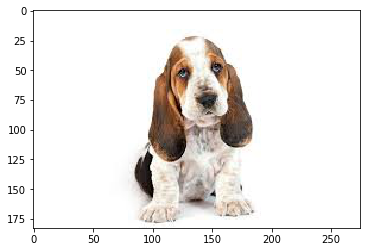

In [74]:
ResNet50_breed_predict('images/basset_hound.jpg')

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [95]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def dog_detector(filepath):
    prediction = ResNet50_predict_labels(filepath)
    return ((prediction <=268) & (prediction >= 151))

def human_detector(filepath):
    img=cv2.imread(filepath)
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def predict_breed(filepath):
    isDog = dog_detector(filepath)
    isHuman = human_detector(filepath)
    if isDog:
        print("Woof woof that's a dog! Calculating breed...")
        breed = ResNet50_breed_predict(filepath)
        return breed
    if isHuman:
        print("This is an image of a person")
        breed = ResNet50_breed_predict(filepath)
        return breed
    else:
        print("No dogs or humans have been detected in your image.")
        img = cv2.imread(filepath)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plot.imshow(cv_rgb)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output seems to be fairly accurate for humans. It is also able to detect faces in high-quality images of humans well. However, the model fails to distinguish other species and groups them in with human faces for some reason! THis is obviously not the desired result -- ideally it would return some type of error message that indicates to the user that they have supplied an image of an entity that is neither a dog or a human. Given more time or resources, there are multiple things we can do to improve the model.

1. Expand the training data to contain a more diverse set of entities, including animals that are not dogs or humans. Additionally, augmenting the training data with transformations like rotation can improve generalization and increase the model's robustness.

2. We can use interpretability and CNN visualization techniques on misclassified images to better understand where the shortcomings are. These techniques show what pixels or areas of images the models focuses on.

3. We can also use the bottleneck features from a different pre-trained model to quickly and efficiently try to improve our predictions.

Woof woof that's a dog!
Dog breed detected: Pomeranian


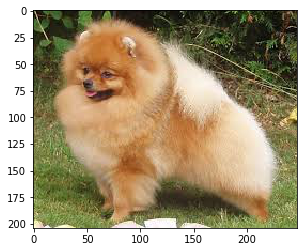

In [88]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
predict_breed('images/pomeranian.jpg')

Woof woof that's a dog! Calculating breed...
Dog breed detected: Doberman pinscher


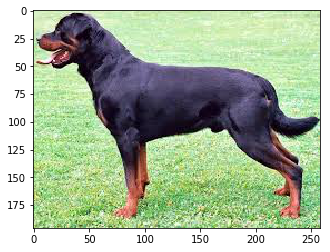

In [90]:
predict_breed('images/rottweiler.jpg')

Woof woof that's a dog! Calculating breed...
Dog breed detected: Lhasa apso


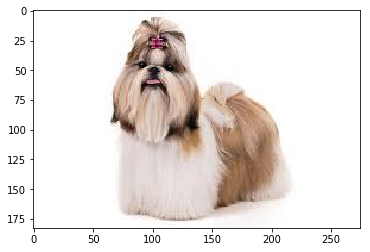

In [92]:
predict_breed('images/shih_tzu2.jpg')

This is an image of a person
If this human were a dog, they would be a Irish water spaniel


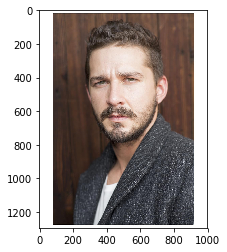

In [93]:
predict_breed('images/person_1.jpg')

This is an image of a person
If this human were a dog, they would be a Xoloitzcuintli


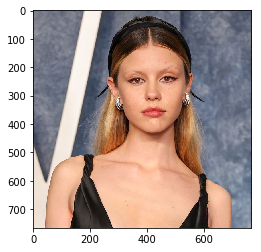

In [94]:
predict_breed('images/person_2.jpg')

This is an image of a person
If this human were a dog, they would be a Silky terrier


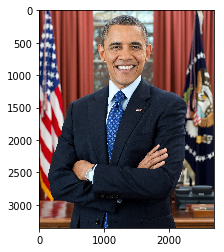

In [96]:
predict_breed('images/person_3.jpg')

This is an image of a person
If this human were a dog, they would be a Plott


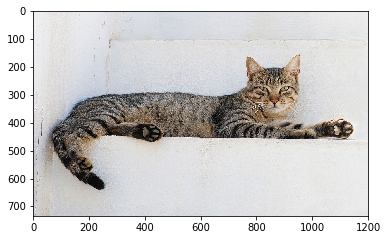

In [97]:
predict_breed('images/cat_q.jpg')

This is an image of a person
If this human were a dog, they would be a Cardigan welsh corgi


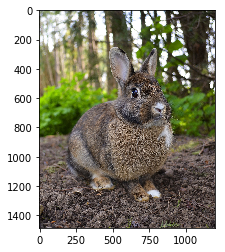

In [98]:
predict_breed('images/rabbit_1.jpg')